# Visualize Convnets
Die Response-Maps der einzelnen Schichten zu visualisieren bietet einen Einblick, welche Konzepte vom Convnets für eine bestimmte Klasse von Bedeutung sind.

In [1]:
from tensorflow.keras.models import load_model

model = load_model('models/cats_and_dogs_small.h5')
model.summary()

W0728 18:00:30.087635 139747449247552 deprecation.py:323] From /home/dominik/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

imgs_path = 'imgs/sample_doggo.jpg'
doggo_img = image.load_img(imgs_path, target_size = (150, 150))
img_arr = image.img_to_array(doggo_img)
print(img_arr.shape) # 150 mal 150 px, 3 Kanäle
img_arr = np.expand_dims(img_arr, axis = 0)
img_arr /= 255. # Modell will Werte zwischen 0 und 1, std. ist 0 bis 255 bei Bildern
print(img_arr.shape) # Eine Batch-Dimension (?)

import matplotlib.pyplot as plt
plt.imshow(img_arr[0]) # first element of batch
plt.show()

(150, 150, 3)
(1, 150, 150, 3)


<Figure size 640x480 with 1 Axes>

Um nun die Response Maps zu ermitteln, brauchen wir ein Modell, das als Output die Aktivierung jeder der Schichten besitzt. Darum wird das Modell nun nicht über `Sequential`, sondern über `Model` zusammengesetzt, was genau dies ermöglicht.

Tensor("conv2d_1/Identity:0", shape=(None, 148, 148, 32), dtype=float32) (None, 148, 148, 32)
(None, 150, 150, 3)
8 (1, 148, 148, 32)
First layer activations, filters 5 to 10
5: große weiße Flächen
6: kleine grüne Flächen
7: Kanten, starke Farbwechsel
8: Wechsel zwischen weiß und schwarz
10: ähnlich 5


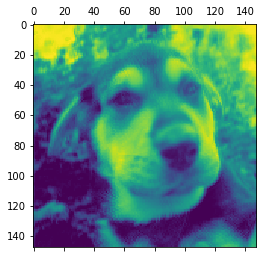

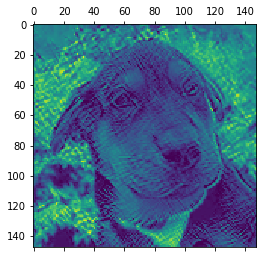

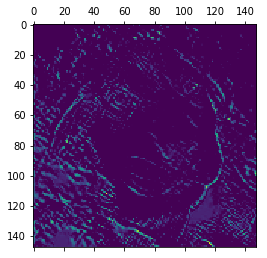

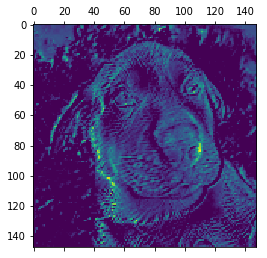

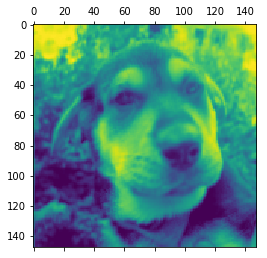

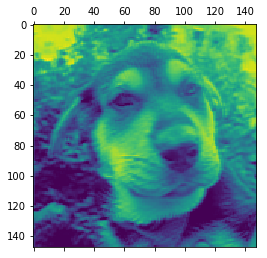

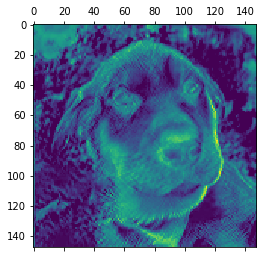

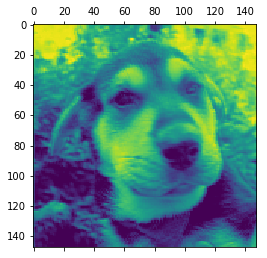

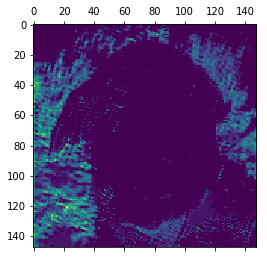

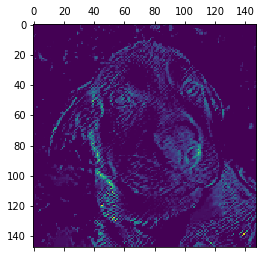

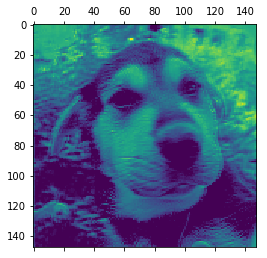

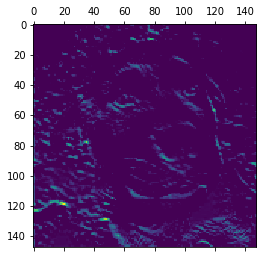

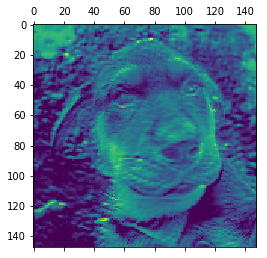

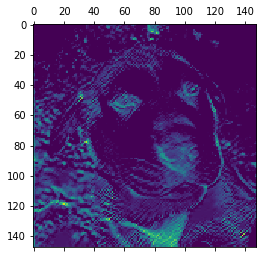

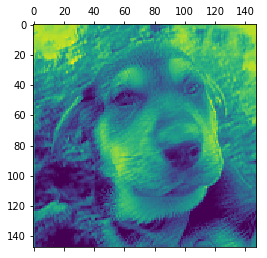

In [3]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
print(layer_outputs[0], layer_outputs[0].shape)
print(model.input.shape)
# Dieses Modell nimmt nun ein Bild als Input und leitet die Daten
# seperat an die verschiedenen Schichten weiter, die alle eine Response Map erzeugen
activation_model = models.Model(
    inputs = model.input,
    outputs = layer_outputs
)

activations = activation_model.predict(img_arr)
print(len(activations), activations[0].shape) #  eight response maps
# Schauen wir uns die Aktivierung der ersten Schicht an:
layer_one = activations[0]
print('First layer activations, filters 5 to 10')

for filter in range(5, 20):
    plt.matshow(layer_one[0, :, :, filter], cmap = 'viridis')
    # visualisiert eine Matrix, cmap ist colormap, Gruppe von Farben für Größe der Zahl
print('5: große weiße Flächen')
print('6: kleine grüne Flächen')
print('7: Kanten, starke Farbwechsel')
print('8: Wechsel zwischen weiß und schwarz')
print('10: ähnlich 5')

(None, 74, 74, 32)
(1, 74, 74, 32)


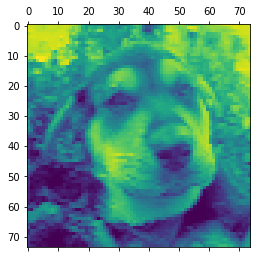

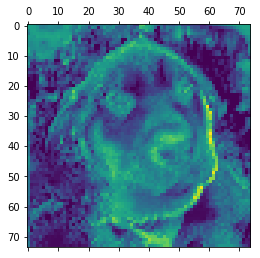

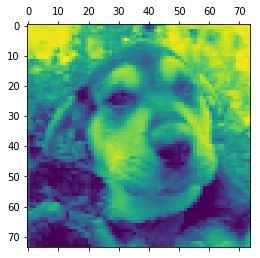

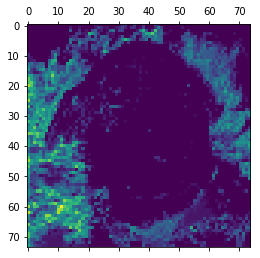

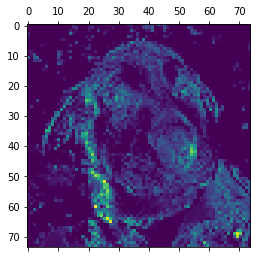

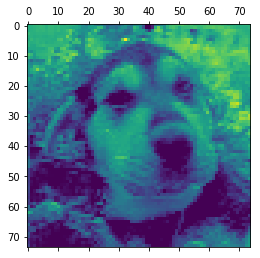

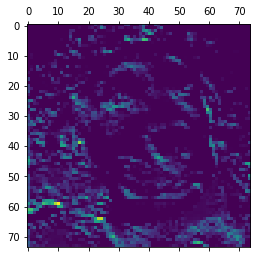

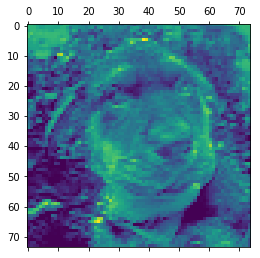

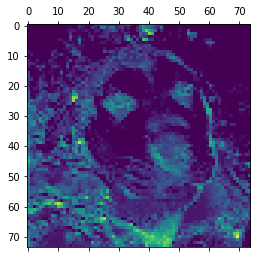

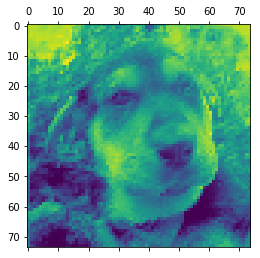

In [4]:
# nun eine Stufe höher:
layer_outputs_2 = layer_outputs[1]
print(layer_outputs_2.shape)
activation_model_2 = models.Model(
    inputs = model.input,
    outputs = layer_outputs_2
)
activations = activation_model_2.predict(img_arr)
print(activations.shape) # batch of one, 74 by 74 left, 32 filters
for filter in range(10, 20):
    plt.matshow(activations[0, :, :, filter], cmap = 'viridis')

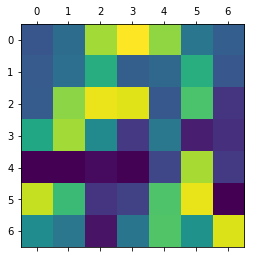

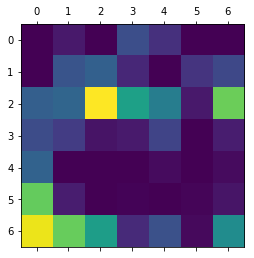

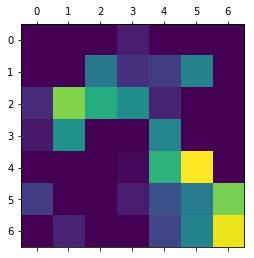

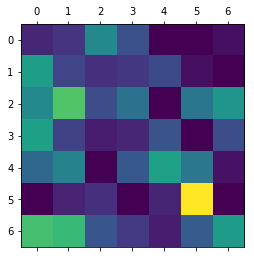

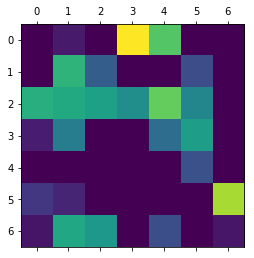

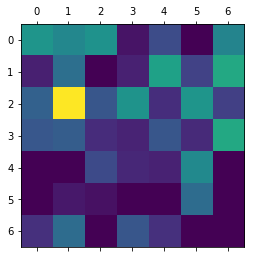

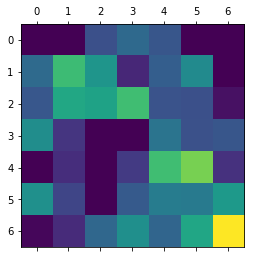

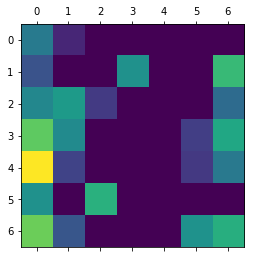

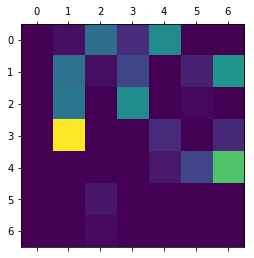

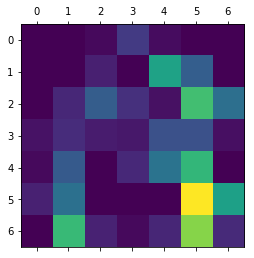

In [5]:
# letzte Stufe: 
layer_outputs_last = layer_outputs[7]
activation_model_3 = models.Model(
    inputs = model.input,
    outputs = layer_outputs_last
)
activations = activation_model_3.predict(img_arr)
for filter in range(10, 20):
    plt.matshow(activations[0, :, :, filter], cmap = 'viridis')

Während die ersten Schichten noch einfache Konzepte wie Kanten kodieren, werden diese Konzepte in höheren Schichten immer abstrakter.
Was hier nicht zu sehen ist, aber dennoch wichtig: mit zunehmender Schicht werden immer weniger der n eigentlichen Filter aktiviert. Das heißt, damit das Convnet etwas auf einem Bild erkennt, muss es nicht alle Filter nutzen, sondern bildet verschiedene Filter für verschiedene Arten von Bildern.

Das spiegelt wider, wie Menschen in ihrer Erinnerung ihre Umwelt wahrnehmen. Wir sind uns abstrakter Konzepte bewusst (Fahrrad mit dreieckigem Rahmen, runden Rädern, Sattel) und nicht jedem einzelnen Detail, um ein Objekt wiederzuerkennen.

## Wie werden die Filter gelernt?
Die Werte der Filtermatrizen werden zufällig initialisiert, meist mithilfe einer Normalverteilung. Diese Werte werden dann während der Backpropagation angepasst, sodass sie nützliche Information im Laufe des Trainings kodieren.

Je mehr Filter also einer Schicht zugeordnet werden, desto mehr Muster können gelernt werden.

## Visualisierung der Filter
Um die Filter am besten zu visualisieren, müssen wir Bilder erzeugen, auf die der Filter möglichst stark reagiert. Dabei starten wir mit einem leeren Bild.
Das wird über die Anpassung des Inputbildes über gradient descent gemacht. Es wird eine loss-Funktion erstellt, die maximiert wird, wenn die Aktivierung des Filters möglichst groß wird. Dazu müssen Funktionen aus dem Keras-Backend genutzt werden.

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend
# import tensorflow as tf
# tf.disable_eager_execution()

# Beispielnetwerk
model = VGG16(
    weights = 'imagenet',
    include_top = False
)
layer_name = 'block3_conv1'
filter_index = 0 # wir wollen Muster für 0ten Filter dieser Schicht finden

layer_output = model.get_layer(layer_name).output # anderer Weg, an die Outputs zu gelangen
loss = backend.mean(layer_output[:, :, :, filter_index])
print(loss, layer_output[:, :, :, filter_index]) # arbeitet mit TensorFlow-Objekten

# Gradienten ermitteln, der in Richtung Maximum zeigt, gegeben des Inputs
gradients = backend.gradients(loss, model.input)[0]
print(gradients)

# Jump to next topic since I was not able to resolve this issue.

Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("strided_slice_3:0", dtype=float32)


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

## Heatmaps der Klassenaktivierungen
Hier wird gezeigt, welche Teile eines Bildes dazu geführt haben, dass es in diese bestimmte Kategorie klassifiziert wurde. Zum Beispiel für die Katzen-vs-Hunde-Klassifikation entstünde eine Heatmap, die indiziert, wie hunde- oder katzenähnlich ein bestimmter Teil des Bildes ist. Eine Heatmap ist hier die Matrix der Scores für ein bestimmtes Inputbild, errechnet für jedes Teil des Bildes. Das Beispiel hier wieder das `VGG16` trainiert auf `imagenet`.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights = 'imagenet')
# wichtig: die vernetzten Schichten werden beibehalten

